In [1]:
%matplotlib inline 

import pickle as pkl 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from scipy.io import loadmat

In [3]:
trainset = loadmat('data/train_32x32.mat')
testset = loadmat('data/test_32x32.mat')

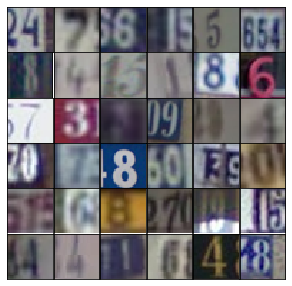

In [4]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5, 5))

for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [5]:
# flat data scale 
# 0 ~ 255 -> -1 ~ 1

def scale(x, feature_ranges=(-1, 1)):
    x = ((x - x.min()) / (255 - x.min()))
    
    min, max = feature_ranges
    x = x * (max - min) + min
    
    return x



In [6]:
# define Dataset Class
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_index = int(len(test['y']) * (1 - val_frac)) # 1 - 0.5 = 0.5
        self.test_x, self.valid_x = test['X'][:,:,:,:split_index], test['X'][:,:,:,split_index:]
        self.test_y, self.valid_y = test['y'][:split_index], test['y'][split_index:]
        self.train_x, self.train_y = train['X'], train['y']
        
        ## convert MATLAB -> TensorFlow
        ## {R, G, B, index} -> {index, R, G, B}
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arrange(len(dataset.train_x))
            np.random.shuffle(idx)
            print(type(idx))
            self.train_x = self_train_x[idx]
            self.train_y = self_train_y[idx]
            
        n_batches = len(self.train_y) // batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

In [7]:
# define placeholder 
# Store input data  as placeholder

def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [8]:
# arxiv.org/pdf/1511.06434.pdf
# Last layer is 32 * 32 * 3
# So we use half layers

def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512)) # (variable length, layer size)
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        # conv
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same') # same: input = output
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8 * 8 * 256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same') # same: input = output
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16 * 16 * 128
        
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')

        out = tf.tanh(logits)
        
        return out 

In [9]:
# define Discriminator
def discriminator(x, reuse=False, alpha=0.2): # Leaky ReLu alpha
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        # 16 * 16 * 64 
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same') # same: input = output
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 8 * 8 * 128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same') # same: input = output
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4 * 4 * 256

        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        

In [10]:
# define loss function
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

In [11]:
# define optimizer function

def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

In [12]:
# define model template Class
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
        

In [13]:
# displaygenetrated image 

def view_samples(epoch, samples, nrows, ncols, figsize=(5, 5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)

    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = (((img - img.min())) * 255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box_forced')
        im = im.show(img, aspect='equal')
        
    plt.subplots(wspace=0, hspace=0)
    
    return fig, axes

In [ ]:
# training function

def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5, 5)):
    saver = tf.train.Saver()
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z:batch_z})
                    print("Epoch:   {}/{}".format(e+1, epochs),
                          "D Loss: {:.4f}".format(train_loss_d),
                          "G Loss: {:.4f}".format(train_loss_g))
    
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    gen_samples = sess.run(generator(net.input_z, 3, reuse=True, training=False),
                                  feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)  
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()
        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    return losses, samples


In [17]:
# initialize hyperparameter & training

real_size = (32, 32, 3)
z_size = 100 
learning_rate = 0.0002
# batch_size = 128
batch_size = 64
# epochs = 25
epochs = 5
alpha = 0.2
beta1 = 0.5

net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

In [18]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10, 5))

Epoch:   1/5 D Loss: 1.8233 G Loss: 0.3309
Epoch:   1/5 D Loss: 0.3726 G Loss: 1.7278
Epoch:   1/5 D Loss: 0.2484 G Loss: 2.1905
Epoch:   1/5 D Loss: 0.1289 G Loss: 2.6453
Epoch:   1/5 D Loss: 0.1520 G Loss: 2.5591
Epoch:   1/5 D Loss: 0.1170 G Loss: 2.9706


KeyboardInterrupt: 

In [ ]:
# Output loss
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='D', alpha=0.5)
plt.plot(losses.T[1], label='G', alpha=0.5)

plt.title('Training Loss')
plt.legend()


